In [1]:
import warnings
import re

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OrdinalEncoder, 
    LabelEncoder, 
    OneHotEncoder,
    PolynomialFeatures
)

from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import VotingClassifier

import sklearn.metrics as skmet

from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

import scikitplot
from sklearn.inspection import PartialDependenceDisplay

import yellowbrick.model_selection as ms
from yellowbrick import classifier

import xgboost
from xgboost import XGBClassifier
from hyperopt.pyll.base import scope
from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    STATUS_OK, 
    Trials
)

import xgbfir
import shap
shap.initjs()

from typing import (
    Any, 
    Dict, 
    Union, 
    Sequence
)

from IPython.display import display, Image
import pydot

from joblib import dump, load

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
warnings.filterwarnings('ignore')

In [2]:
color_palette = ["#CF2011", "#E42313", "#EB5A4E", "#F29189", "#FFFFFF", "#B8B7B7", "#706F6F", "#1D1D1B"]
fp = (matplotlib
      .font_manager
      .FontProperties(fname='/Fonts/roboto/Roboto-Condensed.ttf')
     )
sns.set_palette(color_palette)
sns.set_style("whitegrid", 
              {"grid.color": "#ffffff", 
               "axes.facecolor": "w", 
               "figure.facecolor":"white"})

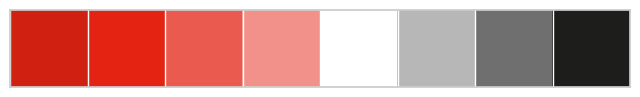

In [3]:
sns.palplot(sns.color_palette())

In [4]:
cmap_name = 'custom_palette'
cm = (plt
      .cm
      .colors
      .LinearSegmentedColormap
      .from_list(cmap_name, 
                 color_palette, 
                 N=len(color_palette)
                )
     )

In [5]:
class TweakCustomerChurn(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        digital_product_cols = ['games_product', 'music_product', 'education_product', 'video_product']
        all_product_cols = ['games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp']
        
        return (X
                .rename(columns=lambda col: re.compile(r'[^a-zA-Z0-9_]+').sub('_', col.lower()))
                .assign(tenure_segmentation=lambda df_: np.where(df_.tenure_months < 4, "low", np.where(df_.tenure_months < 12, "medium", "high")),
                        any_digital_product=lambda df_: np.where((df_.games_product == "Yes") | (df_.music_product == "Yes") | (df_.education_product == "Yes") | (df_.video_product == "Yes"), 1, 0),
                        all_digital_product=lambda df_: np.where((df_.games_product == "Yes") & (df_.music_product == "Yes") & (df_.education_product == "Yes") & (df_.video_product == "Yes"), 1, 0),
                        total_digital_product_used=lambda df_: df_[digital_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_product_utilisation=lambda df_: df_[all_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_spending=lambda df_: df_.tenure_months.mul(df_.monthly_purchase_thou_idr_),
                        net_cltv_total_spending=lambda df_: df_.cltv_predicted_thou_idr_.sub(df_.total_spending)
                        # spending_per_tenure=lambda df_: df_.monthly_purchase_thou_idr_.div(df_.tenure_months),
                        # cltv_monthly_purchase_ratio=lambda df_: df_.cltv_predicted_thou_idr_.div(df_.monthly_purchase_thou_idr_),
                        ) #tbc
                .astype({**{k: "int8"
                            for k in ["tenure_months", "any_digital_product", "all_digital_product", "total_digital_product_used", "total_product_utilisation"]},
                         **{k: "float16"
                            for k in ["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"]},
                         **{k: "category"
                            for k in ["tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "call_center", "video_product", "use_myapp", "payment_method"]}})
                .reindex(columns=["tenure_months", "tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "video_product", "any_digital_product", "all_digital_product", "total_digital_product_used", "call_center", "use_myapp", "total_product_utilisation", "payment_method", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"])
               )

In [6]:
# Load the model from the file
loaded_model_xgboost = load('best_model_telco_churn.joblib')

In [7]:
# Load the pipeline from the file
loaded_pipeline_xgboost = load('best_pipeline_telco_churn.joblib')

In [8]:
loaded_pipeline_xgboost

Pipeline(steps=[('tweak_customer_churn', TweakCustomerChurn()),
                ('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_categorical_features',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['location', 'device_class',
                                                   'games_product',
                                                   'music_product',
                                                   'education_product',
                                                   'video_product',
                                                   'call_center', 'use_myapp',
                                                   'payment_method']),
                                                 ('orde_categorical_features',
                                                  Pipeline(steps=[('orde',
                                                                   OrdinalEncoder(dtype='float'))]),
                                                  ['tenure_segmentation'])],
                                   verbose=0,
                                   verbose_feature_names_out=False))])

In [9]:
# Load the trials from the file
loaded_trials = load('hyperopt_trials.joblib')

In [10]:
df = (pd
      .read_excel('Telco_customer_churn_adapted_v2.xlsx')
     )

In [11]:
label_encoder = LabelEncoder()
df = (df
      .rename(columns={'Churn Label': 'churn_label'})
      .assign(churn_label=lambda df_: label_encoder.fit_transform(df_.churn_label))
      .astype({'churn_label': 'int8'})
     )
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),churn_label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,1,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,1,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,1,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,1,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,1,106.816666,-6.2,6942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,0,106.816666,-6.2,6897.8
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,0,106.816666,-6.2,2782.0
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,0,106.816666,-6.2,7228.0
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,0,106.816666,-6.2,3630.9


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Customer ID', 'Latitude', 'Longitude', 'churn_label']),
                                                    df[['churn_label']].values.ravel(),
                                                    test_size=0.2,
                                                    stratify=df[['churn_label']].values.ravel(),
                                                    random_state=42)

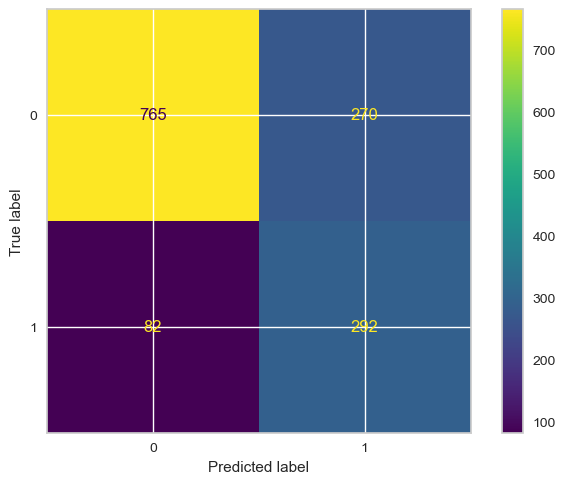

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_test, loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test)))).plot();

In [14]:
print(f'Accuracy score: {accuracy_score(y_test, loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))[:, 1])}')

Accuracy score: 0.7501774308019872
Precision score: 0.5195729537366548
Recall score: 0.7807486631016043
F1 score: 0.6239316239316239
ROC-AUC score: 0.8378555374719059
Average Precision Score: 0.65018430835671


In [15]:
input_features = (loaded_pipeline_xgboost
                  .named_steps['tweak_customer_churn']
                  .transform(X_test)
                  .columns
                 )

feature_names = (loaded_pipeline_xgboost
                 .named_steps['col_trans']
                 .get_feature_names_out(input_features=input_features)
                )
feature_names

array(['location_Jakarta', 'device_class_Low End', 'device_class_Mid End',
       'games_product_No internet service', 'games_product_Yes',
       'music_product_No internet service', 'music_product_Yes',
       'education_product_No internet service', 'education_product_Yes',
       'video_product_No internet service', 'video_product_Yes',
       'call_center_Yes', 'use_myapp_No internet service',
       'use_myapp_Yes', 'payment_method_Debit',
       'payment_method_Digital Wallet', 'payment_method_Pulsa',
       'tenure_segmentation', 'tenure_months', 'any_digital_product',
       'all_digital_product', 'total_digital_product_used',
       'total_product_utilisation', 'monthly_purchase_thou_idr_',
       'cltv_predicted_thou_idr_', 'total_spending',
       'net_cltv_total_spending'], dtype=object)

### Trials Object

In [16]:
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

hyper2hr = trial2df(loaded_trials)

In [17]:
hyper2hr.to_csv('hyperopt_trials.csv', index=False)

In [18]:
(hyper2hr
 .corr(method='spearman')
 .style
 .background_gradient(cmap=cm, vmin=-1, vmax=1)
 .set_sticky(axis=0)
)

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss,tid
colsample_bytree,1.000000,0.276220,-0.244656,-0.231236,0.030363,0.074482,0.019634,-0.273183,-0.157444,0.020908,-0.386823
gamma,0.276220,1.000000,-0.364908,-0.317361,-0.179850,0.002598,0.258530,0.018770,0.129097,0.458464,-0.398392
learning_rate,-0.244656,-0.364908,1.000000,0.303611,0.235392,-0.012991,-0.120600,0.173909,0.004284,-0.394406,0.442832
max_depth,-0.231236,-0.317361,0.303611,1.000000,0.165175,0.054496,-0.241760,0.084354,0.066140,-0.368591,0.446729
min_child_weight,0.030363,-0.179850,0.235392,0.165175,1.000000,0.105660,-0.357768,0.027531,-0.183546,-0.449250,0.236916
n_estimators,0.074482,0.002598,-0.012991,0.054496,0.105660,1.000000,-0.025116,-0.011259,-0.153294,-0.198408,0.030312
reg_alpha,0.019634,0.258530,-0.120600,-0.241760,-0.357768,-0.025116,1.000000,0.009601,0.215926,0.586987,-0.231719
reg_lambda,-0.273183,0.018770,0.173909,0.084354,0.027531,-0.011259,0.009601,1.000000,0.146355,-0.020974,0.266055
subsample,-0.157444,0.129097,0.004284,0.066140,-0.183546,-0.153294,0.215926,0.146355,1.000000,0.156047,0.084044
loss,0.020908,0.458464,-0.394406,-0.368591,-0.449250,-0.198408,0.586987,-0.020974,0.156047,1.000000,-0.334119


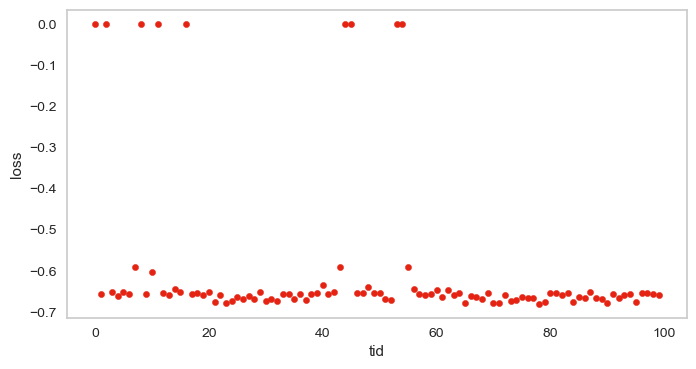

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot
 .scatter(x='tid', y='loss', color=color_palette[1], ax=ax)
);

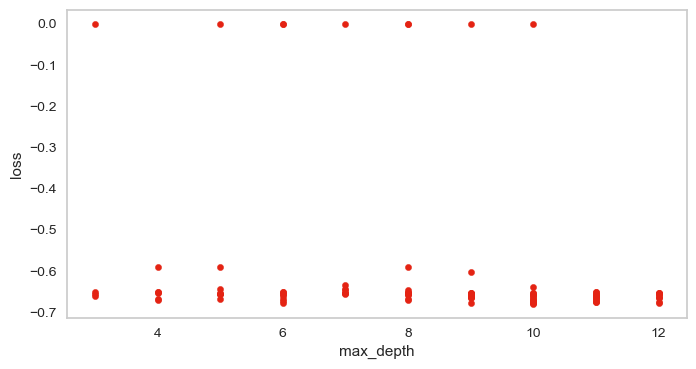

In [20]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot
 .scatter(x='max_depth', y='loss', alpha=1, color=color_palette[1], ax=ax)
);

In [21]:
def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFraem column.
    
    This fn adds random noise to the values in a specified column of
    a Pandas DataFrame. The noise is uniform random noise with a range of amount
    centered around zero. The fn returns a Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2, size=df.shape[0])
    return df[col] + vals

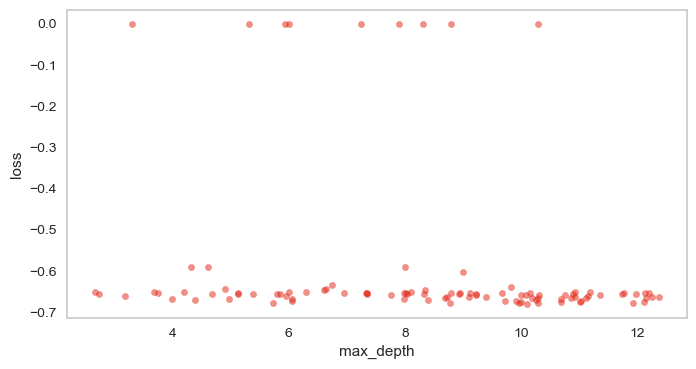

In [22]:
fig.clf()
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .assign(max_depth = lambda df: jitter(df, 'max_depth', amount=.8))
 .plot
 .scatter(x='max_depth', y='loss', alpha=.5, color=color_palette[1], ax=ax)
);

<Axes: xlabel='reg_alpha', ylabel='loss'>

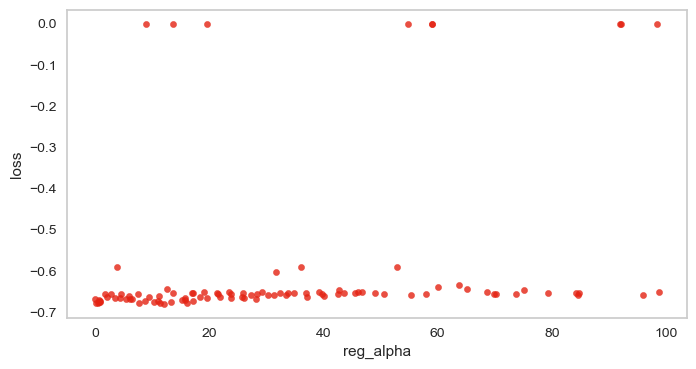

In [23]:
fig.clf()
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='reg_alpha', y='loss', alpha=.8, color=color_palette[1], cmap='viridis', ax=ax))

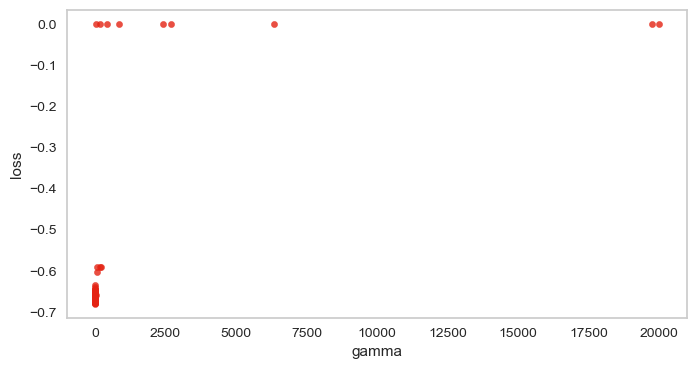

In [24]:
fig.clf()
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='gamma', y='loss', alpha=.8, color=color_palette[1], cmap='viridis', ax=ax));

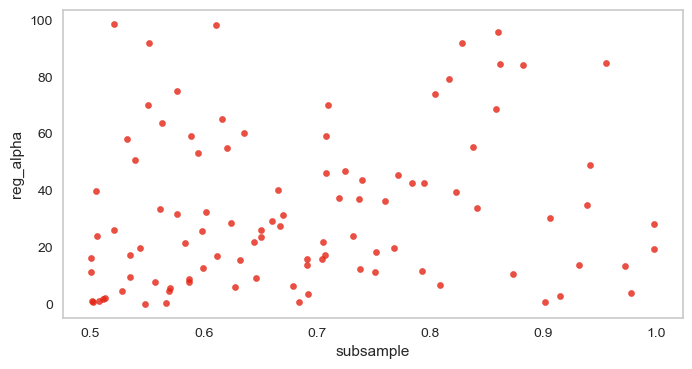

In [25]:
fig.clf()
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='subsample', y='reg_alpha', alpha=.8, color=color_palette[1], cmap='viridis', ax=ax));

In [26]:
def get_tpr_fpr(probs, y_truth):
    """
    Given predicted probabilities and ground truth labels, 
    calculates TPR and FPR
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

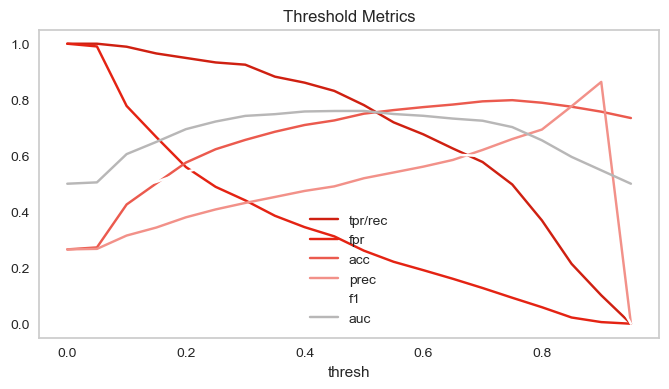

In [27]:
vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score,
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)

fig.clf()
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc',
                             'prec', 'rec', 'f1', 'auc'])
   .drop(columns='rec')
   .set_index('thresh')
   .plot(ax=ax, title='Threshold Metrics')
);

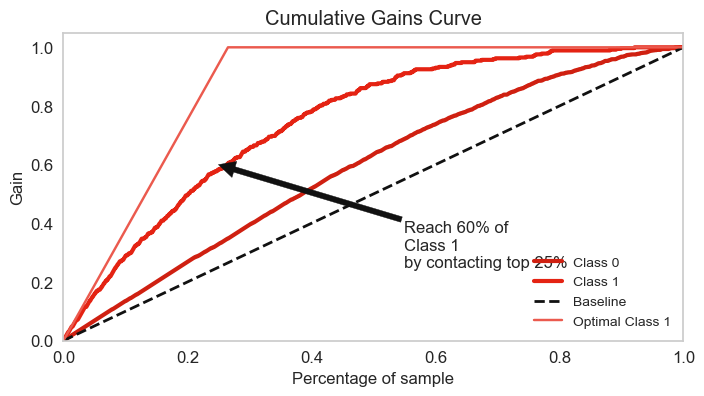

In [28]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of \nClass 1 \nby contacting top 25%', xy=(.25, .6),
            xytext=(.55, .25), arrowprops={'color': 'k'})
ax.legend();

**Notes:**

1. The Cumulative Gain Curve provides a way to assess how well the loaded_model_xgboost model ranks the positive class.
2. A steeper curve indicates that the model is better at ranking positive instances higher. The curve should ideally be close to the 'Optimal Class 1' line.
3. How to interpret the data? By examining the top 25% of samples that the model has most confidently labeled as positive, we would have found 60% of all actual positive cases.

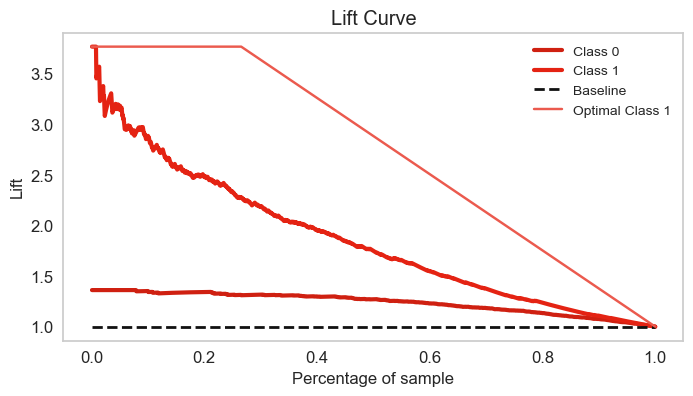

In [29]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend();

**Notes:**
1. To interpret this Lift Curve, examine how much higher the curve is above the y=1 line. This will give you an idea of how much more effective your model (loaded_model_xgboost) is compared to a random model.
2. Also, compare the curve to the 'Optimal Class 1' line to gauge how close your model is to the ideal scenario. The area where the curve is closest to the 'Optimal Class 1' line is where your model is most effective at identifying true positive cases.

### Feature Importance

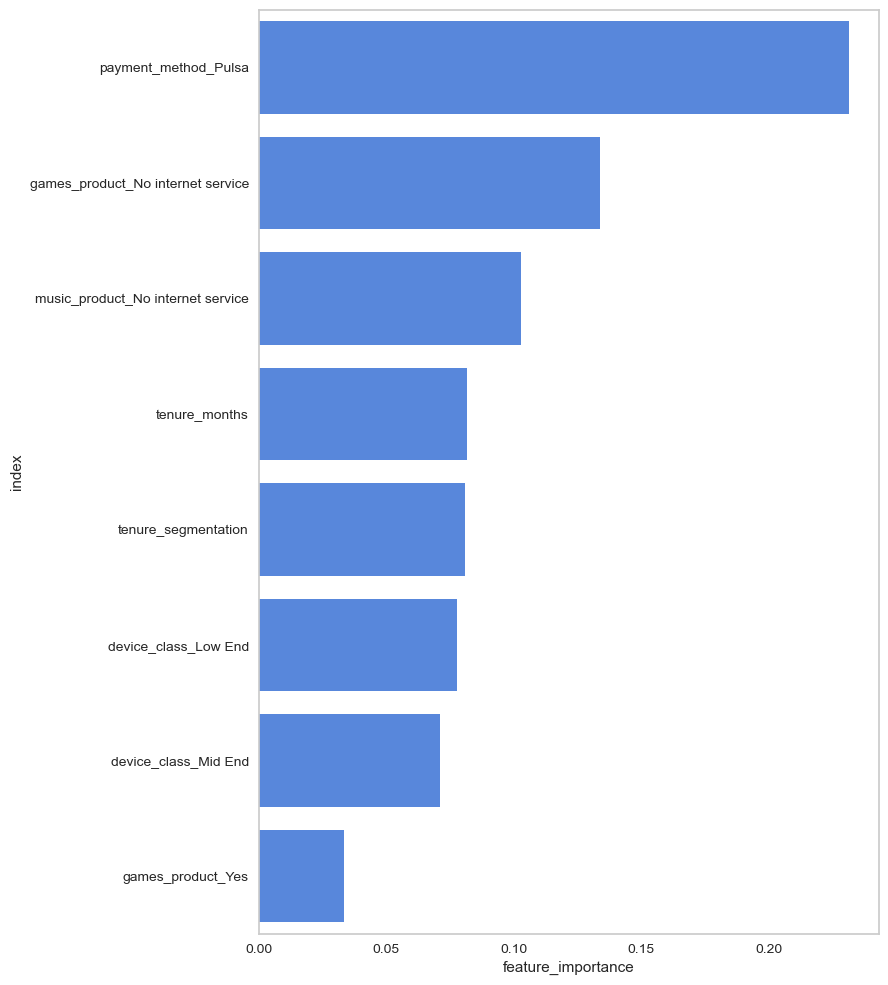

In [57]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(loaded_model_xgboost.feature_importances_, index=feature_names)
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 .theme({"axes.prop_cycle": matplotlib.cycler(color="#1155ccff")})
 .on(ax)
 .show())

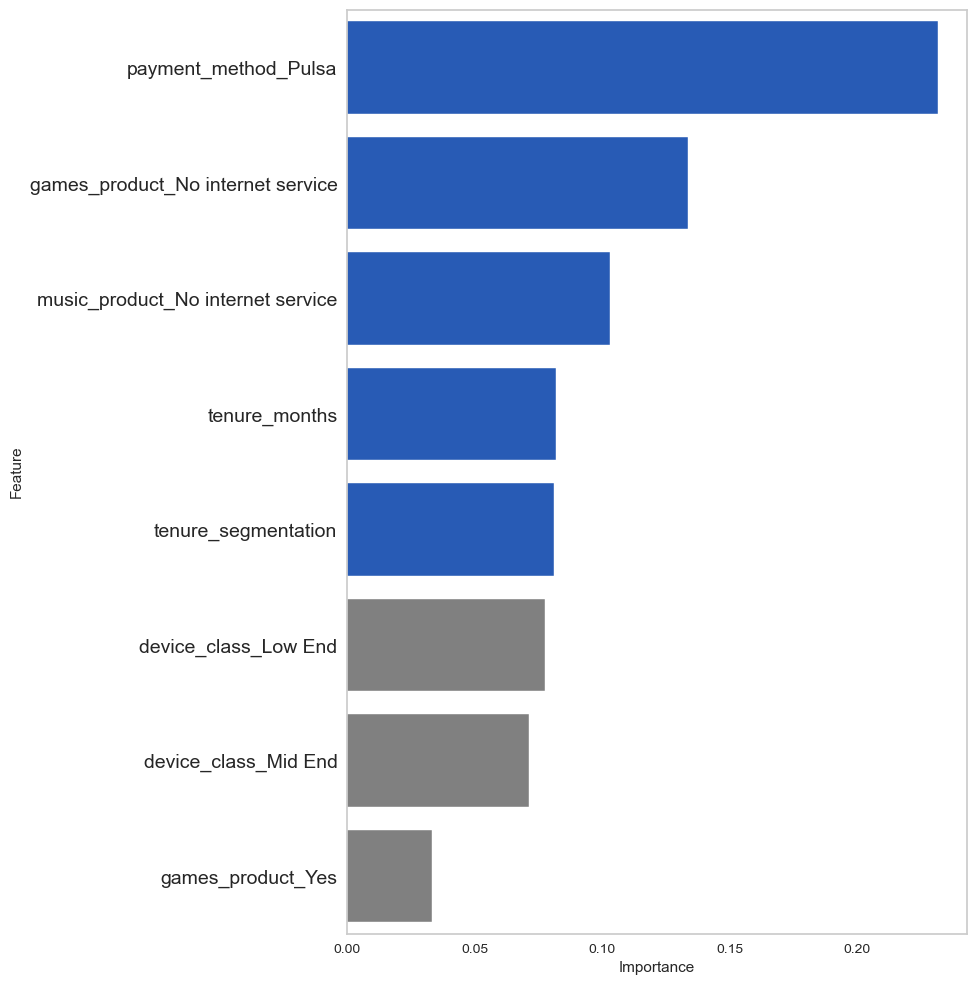

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming 'loaded_model_xgboost' and 'feature_names' are defined earlier in the code.
# Create the DataFrame of feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': loaded_model_xgboost.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Determine the colors for each feature - top 5 in blue, rest in grey
top_colors = ["#1155ccff" if i < 5 else "grey" for i in range(len(feature_importances))]

# Now plot using seaborn
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances.iloc[:8],  # We only plot the top 8 features
    palette=top_colors
)

# Enlarge y-axis font size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

# If you want to set the font size for all ytick labels globally, you can also do:
# plt.yticks(fontsize=14)

plt.show()


### Surrogate Models (Decision Tree)

In [40]:
sur_reg_sk_depth3 = DecisionTreeRegressor(max_depth=3)
sur_reg_sk_depth3.fit(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names), 
                      loaded_model_xgboost.predict_proba(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names))[:,-1])

DecisionTreeRegressor(max_depth=3)

In [50]:
sur_reg_sk_depth4 = DecisionTreeRegressor(max_depth=4)
sur_reg_sk_depth4.fit(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names), 
                      loaded_model_xgboost.predict_proba(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names))[:,-1])

DecisionTreeRegressor(max_depth=4)

In [31]:
sur_reg_sk = DecisionTreeRegressor(max_depth=5)
sur_reg_sk.fit(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names), 
               loaded_model_xgboost.predict_proba(pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names))[:,-1])

DecisionTreeRegressor(max_depth=5)

In [51]:
# Generate predictions from both models
xgb_test_predictions = loaded_model_xgboost.predict(loaded_pipeline_xgboost.transform(X_test))
dt_test_predictions_depth3 = np.where(sur_reg_sk_depth3.predict(loaded_pipeline_xgboost.transform(X_test)) > 0.5, 1, 0)
dt_test_predictions_depth4 = np.where(sur_reg_sk_depth4.predict(loaded_pipeline_xgboost.transform(X_test)) > 0.5, 1, 0)
dt_test_predictions = np.where(sur_reg_sk.predict(loaded_pipeline_xgboost.transform(X_test)) > 0.5, 1, 0)

In [33]:
print(f'Accuracy score: {accuracy_score(y_test, xgb_test_predictions)}')
print(f'Precision score: {precision_score(y_test, xgb_test_predictions)}')
print(f'Recall score: {recall_score(y_test, xgb_test_predictions)}')
print(f'F1 score: {f1_score(y_test, xgb_test_predictions)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, loaded_model_xgboost.predict_proba(loaded_pipeline_xgboost.transform(X_test))[:, 1])}')

Accuracy score: 0.7501774308019872
Precision score: 0.5195729537366548
Recall score: 0.7807486631016043
F1 score: 0.6239316239316239
ROC-AUC score: 0.8378555374719059
Average Precision Score: 0.65018430835671


In [42]:
print(f'Accuracy score: {accuracy_score(y_test, dt_test_predictions_depth3)}')
print(f'Precision score: {precision_score(y_test, dt_test_predictions_depth3)}')
print(f'Recall score: {recall_score(y_test, dt_test_predictions_depth3)}')
print(f'F1 score: {f1_score(y_test, dt_test_predictions_depth3)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, dt_test_predictions_depth3)}')
print(f'Average Precision Score: {average_precision_score(y_test, dt_test_predictions_depth3)}')

Accuracy score: 0.7154009936124911
Precision score: 0.47768595041322315
Recall score: 0.7727272727272727
F1 score: 0.5903983656792646
ROC-AUC score: 0.7337066315327184
Average Precision Score: 0.42944743435860167


In [52]:
print(f'Accuracy score: {accuracy_score(y_test, dt_test_predictions_depth4)}')
print(f'Precision score: {precision_score(y_test, dt_test_predictions_depth4)}')
print(f'Recall score: {recall_score(y_test, dt_test_predictions_depth4)}')
print(f'F1 score: {f1_score(y_test, dt_test_predictions_depth4)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, dt_test_predictions_depth4)}')
print(f'Average Precision Score: {average_precision_score(y_test, dt_test_predictions_depth4)}')

Accuracy score: 0.7430801987224982
Precision score: 0.5111940298507462
Recall score: 0.732620320855615
F1 score: 0.6021978021978022
ROC-AUC score: 0.7397401121186288
Average Precision Score: 0.4454834549636185


In [34]:
print(f'Accuracy score: {accuracy_score(y_test, dt_test_predictions)}')
print(f'Precision score: {precision_score(y_test, dt_test_predictions)}')
print(f'Recall score: {recall_score(y_test, dt_test_predictions)}')
print(f'F1 score: {f1_score(y_test, dt_test_predictions)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, dt_test_predictions)}')
print(f'Average Precision Score: {average_precision_score(y_test, dt_test_predictions)}')

Accuracy score: 0.7196593328601846
Precision score: 0.48292682926829267
Recall score: 0.7941176470588235
F1 score: 0.6006066734074824
ROC-AUC score: 0.7434356351236145
Average Precision Score: 0.4381494043721801


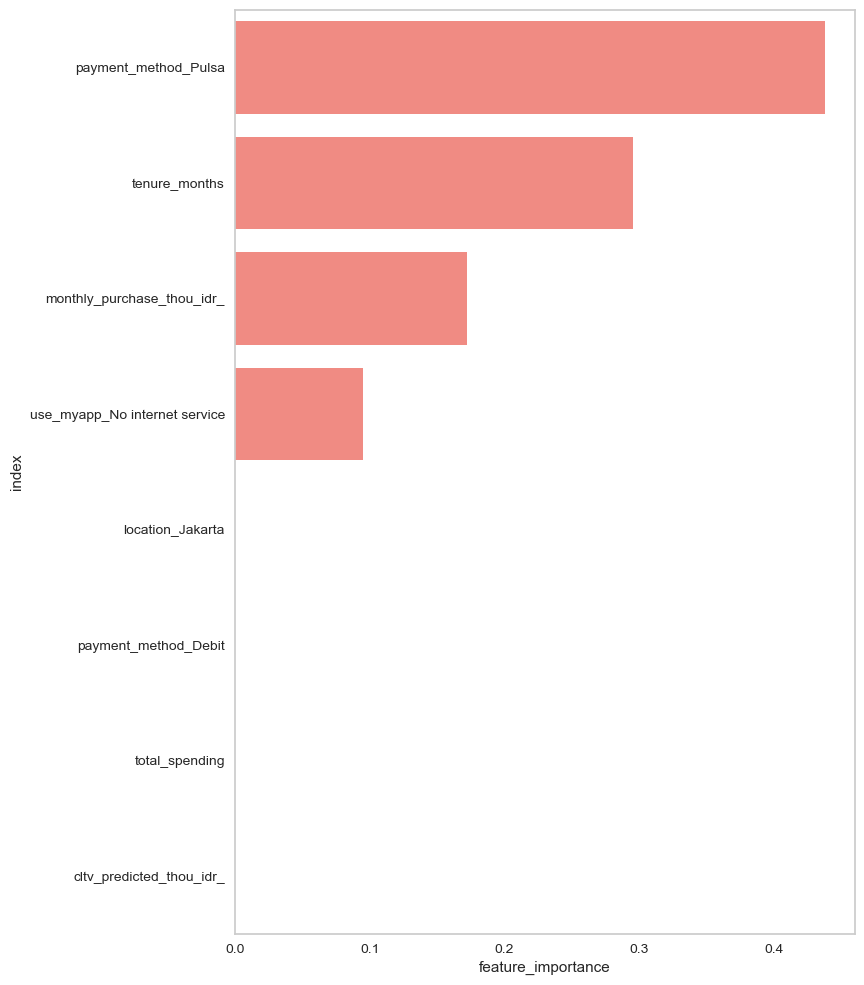

In [43]:
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(sur_reg_sk_depth3.feature_importances_, index=feature_names)
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[2]])})
 .on(ax)
 .show())

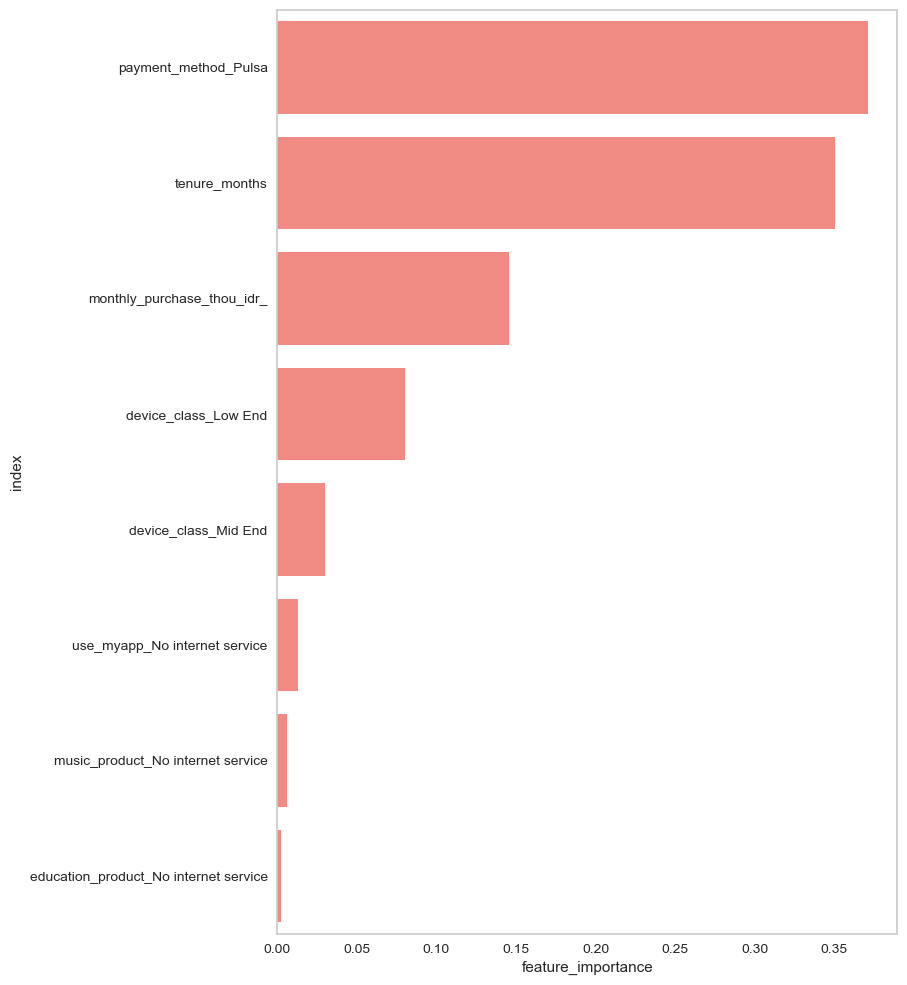

In [53]:
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(sur_reg_sk_depth4.feature_importances_, index=feature_names)
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[2]])})
 .on(ax)
 .show())

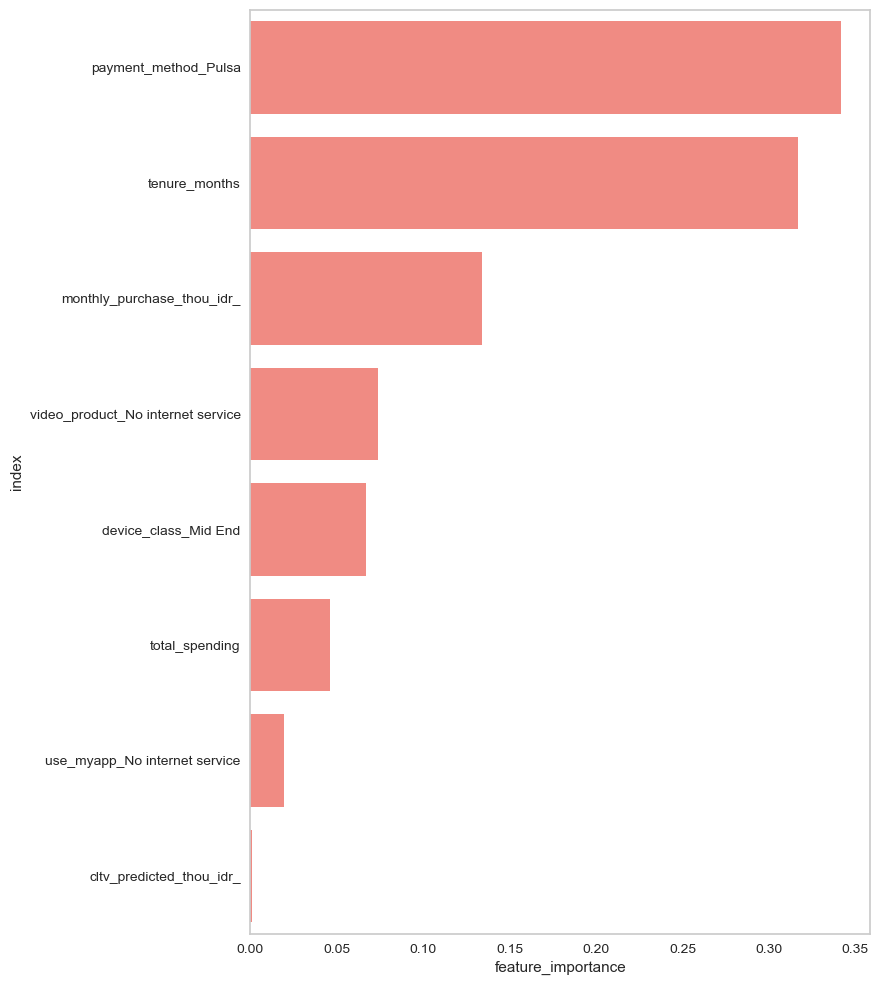

In [35]:
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(sur_reg_sk.feature_importances_, index=feature_names)
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[2]])})
 .on(ax)
 .show())

In [47]:
export_graphviz(sur_reg_sk_depth3, 
                out_file='img/sur-skdepth3.dot',
                feature_names=feature_names, 
                filled=True, 
                rotate=True,
                fontname='Roboto Condensed')

In [48]:
# Convert .dot to .png
(graph,) = pydot.graph_from_dot_file('img/sur-skdepth3.dot')
graph.write_png('img/sur-skdepth3.png')

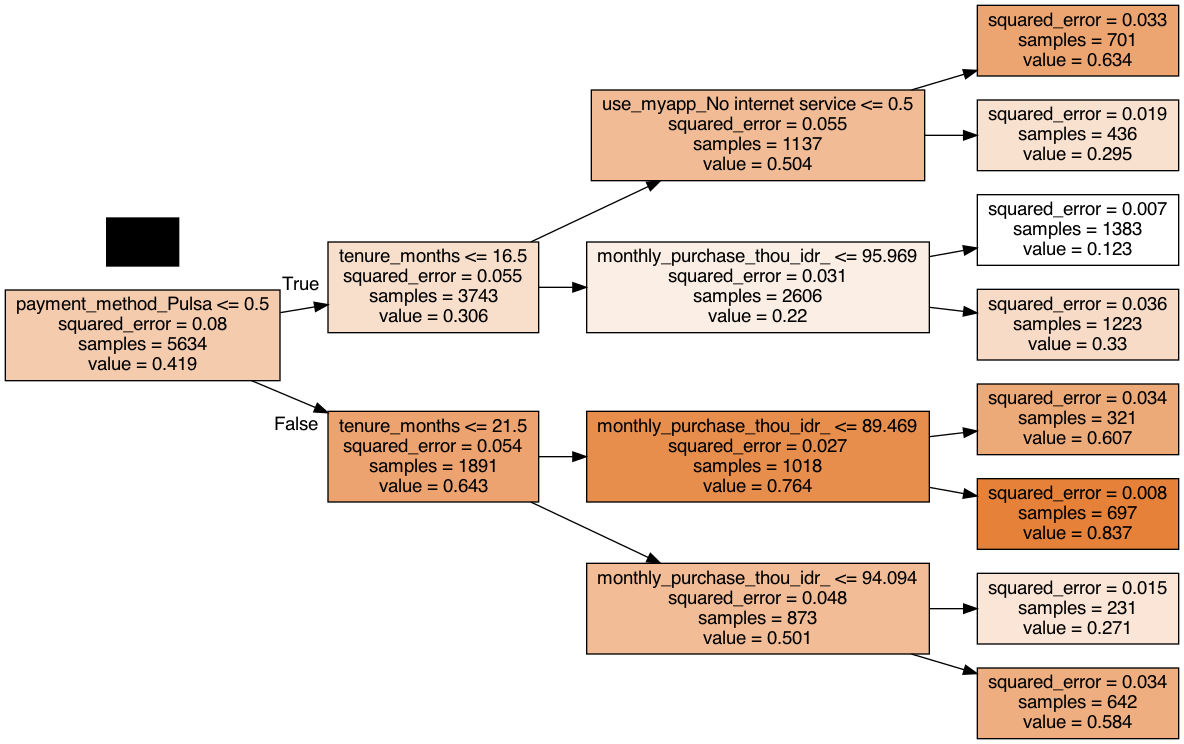

In [49]:
# Display the .png in Jupyter Lab
display(Image(filename='img/sur-skdepth3.png'))

In [54]:
export_graphviz(sur_reg_sk_depth4, 
                out_file='img/sur-skdepth4.dot',
                feature_names=feature_names, 
                filled=True, 
                rotate=True,
                fontname='Roboto Condensed')

In [55]:
# Convert .dot to .png
(graph,) = pydot.graph_from_dot_file('img/sur-skdepth4.dot')
graph.write_png('img/sur-skdepth4.png')

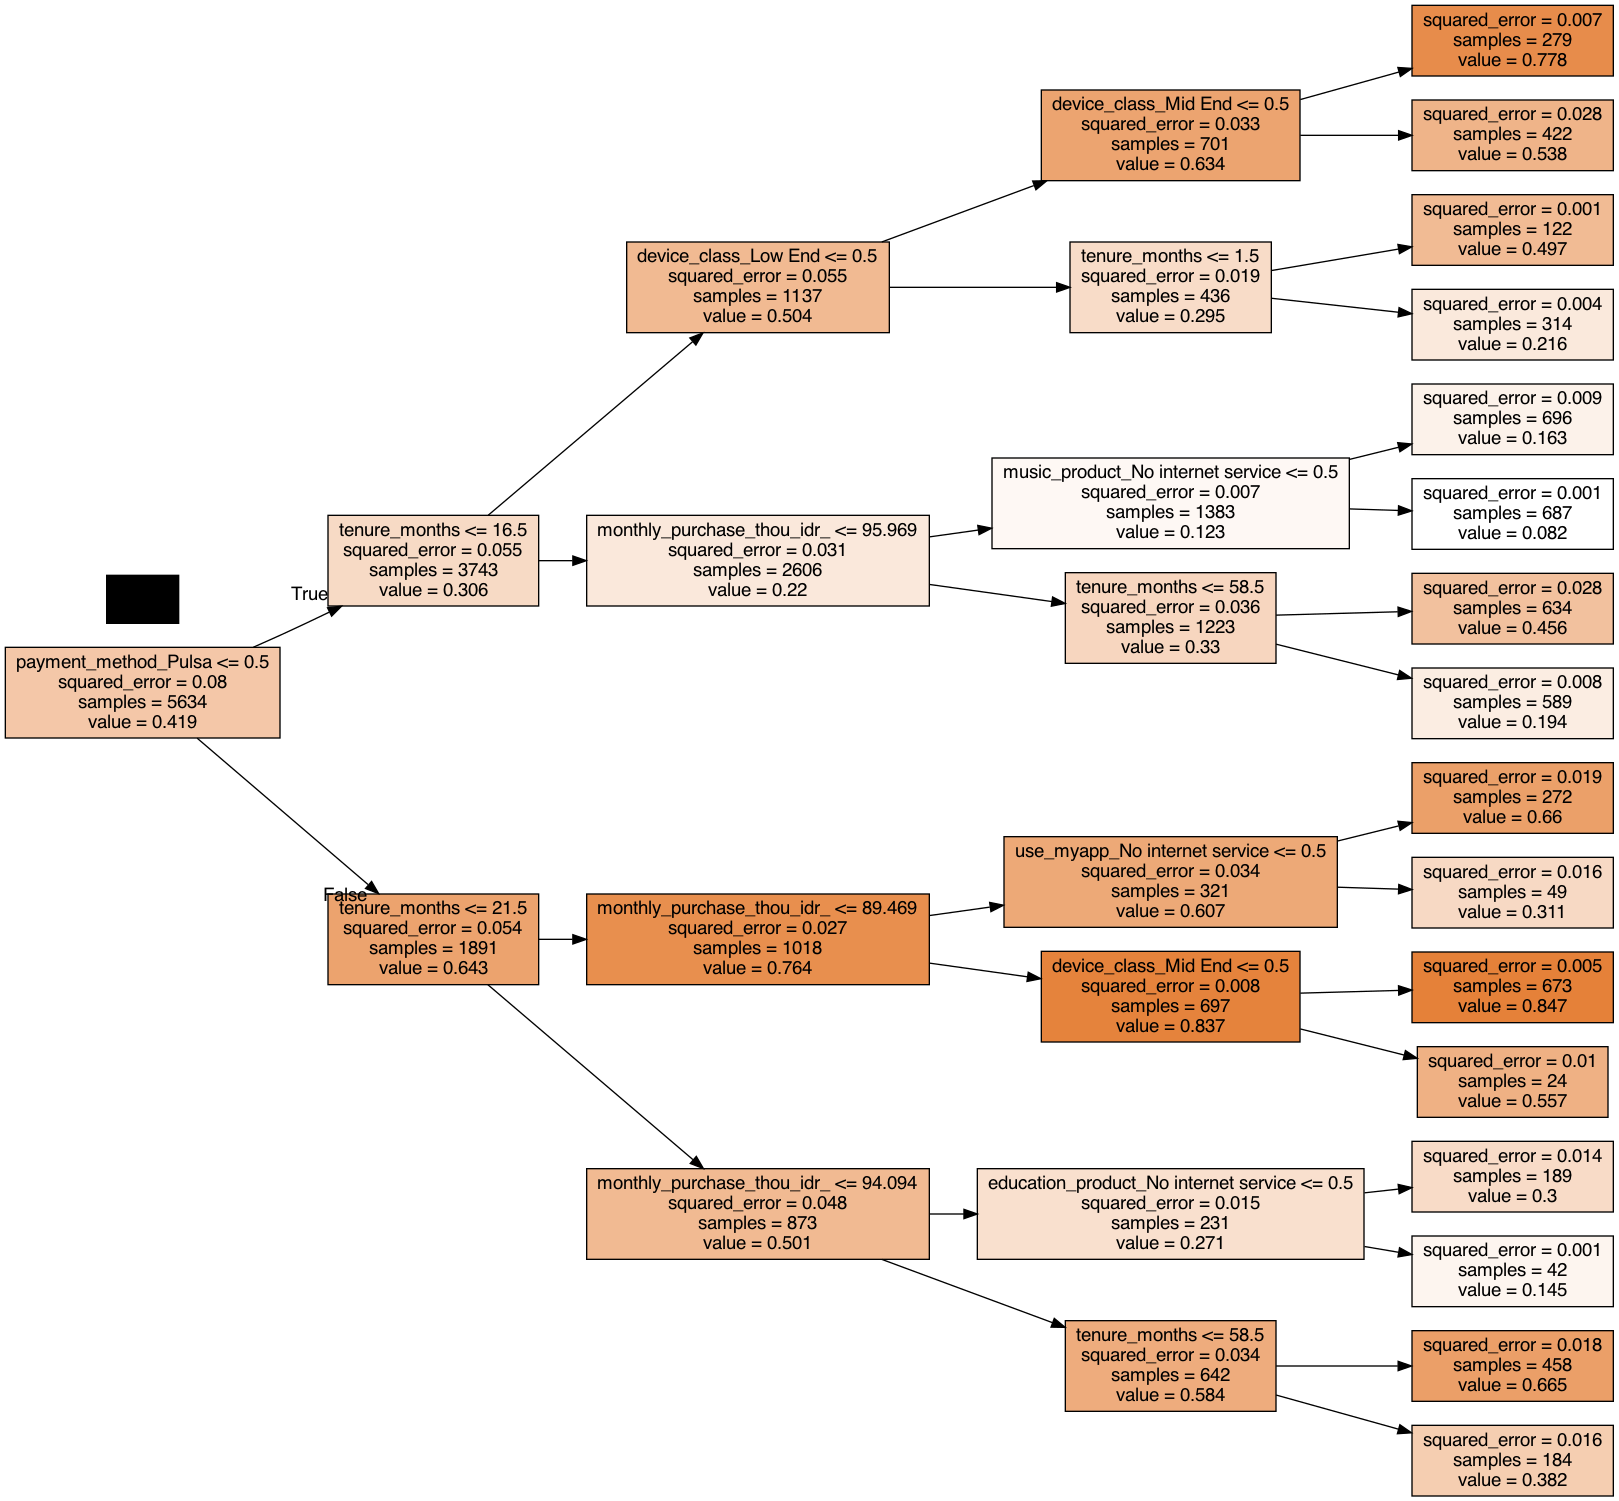

In [56]:
# Display the .png in Jupyter Lab
display(Image(filename='img/sur-skdepth4.png'))

In [36]:
export_graphviz(sur_reg_sk, 
                out_file='img/sur-sk.dot',
                feature_names=feature_names, 
                filled=True, 
                rotate=True,
                fontname='Roboto Condensed')

In [37]:
# Convert .dot to .png
(graph,) = pydot.graph_from_dot_file('img/sur-sk.dot')
graph.write_png('img/sur-sk.png')

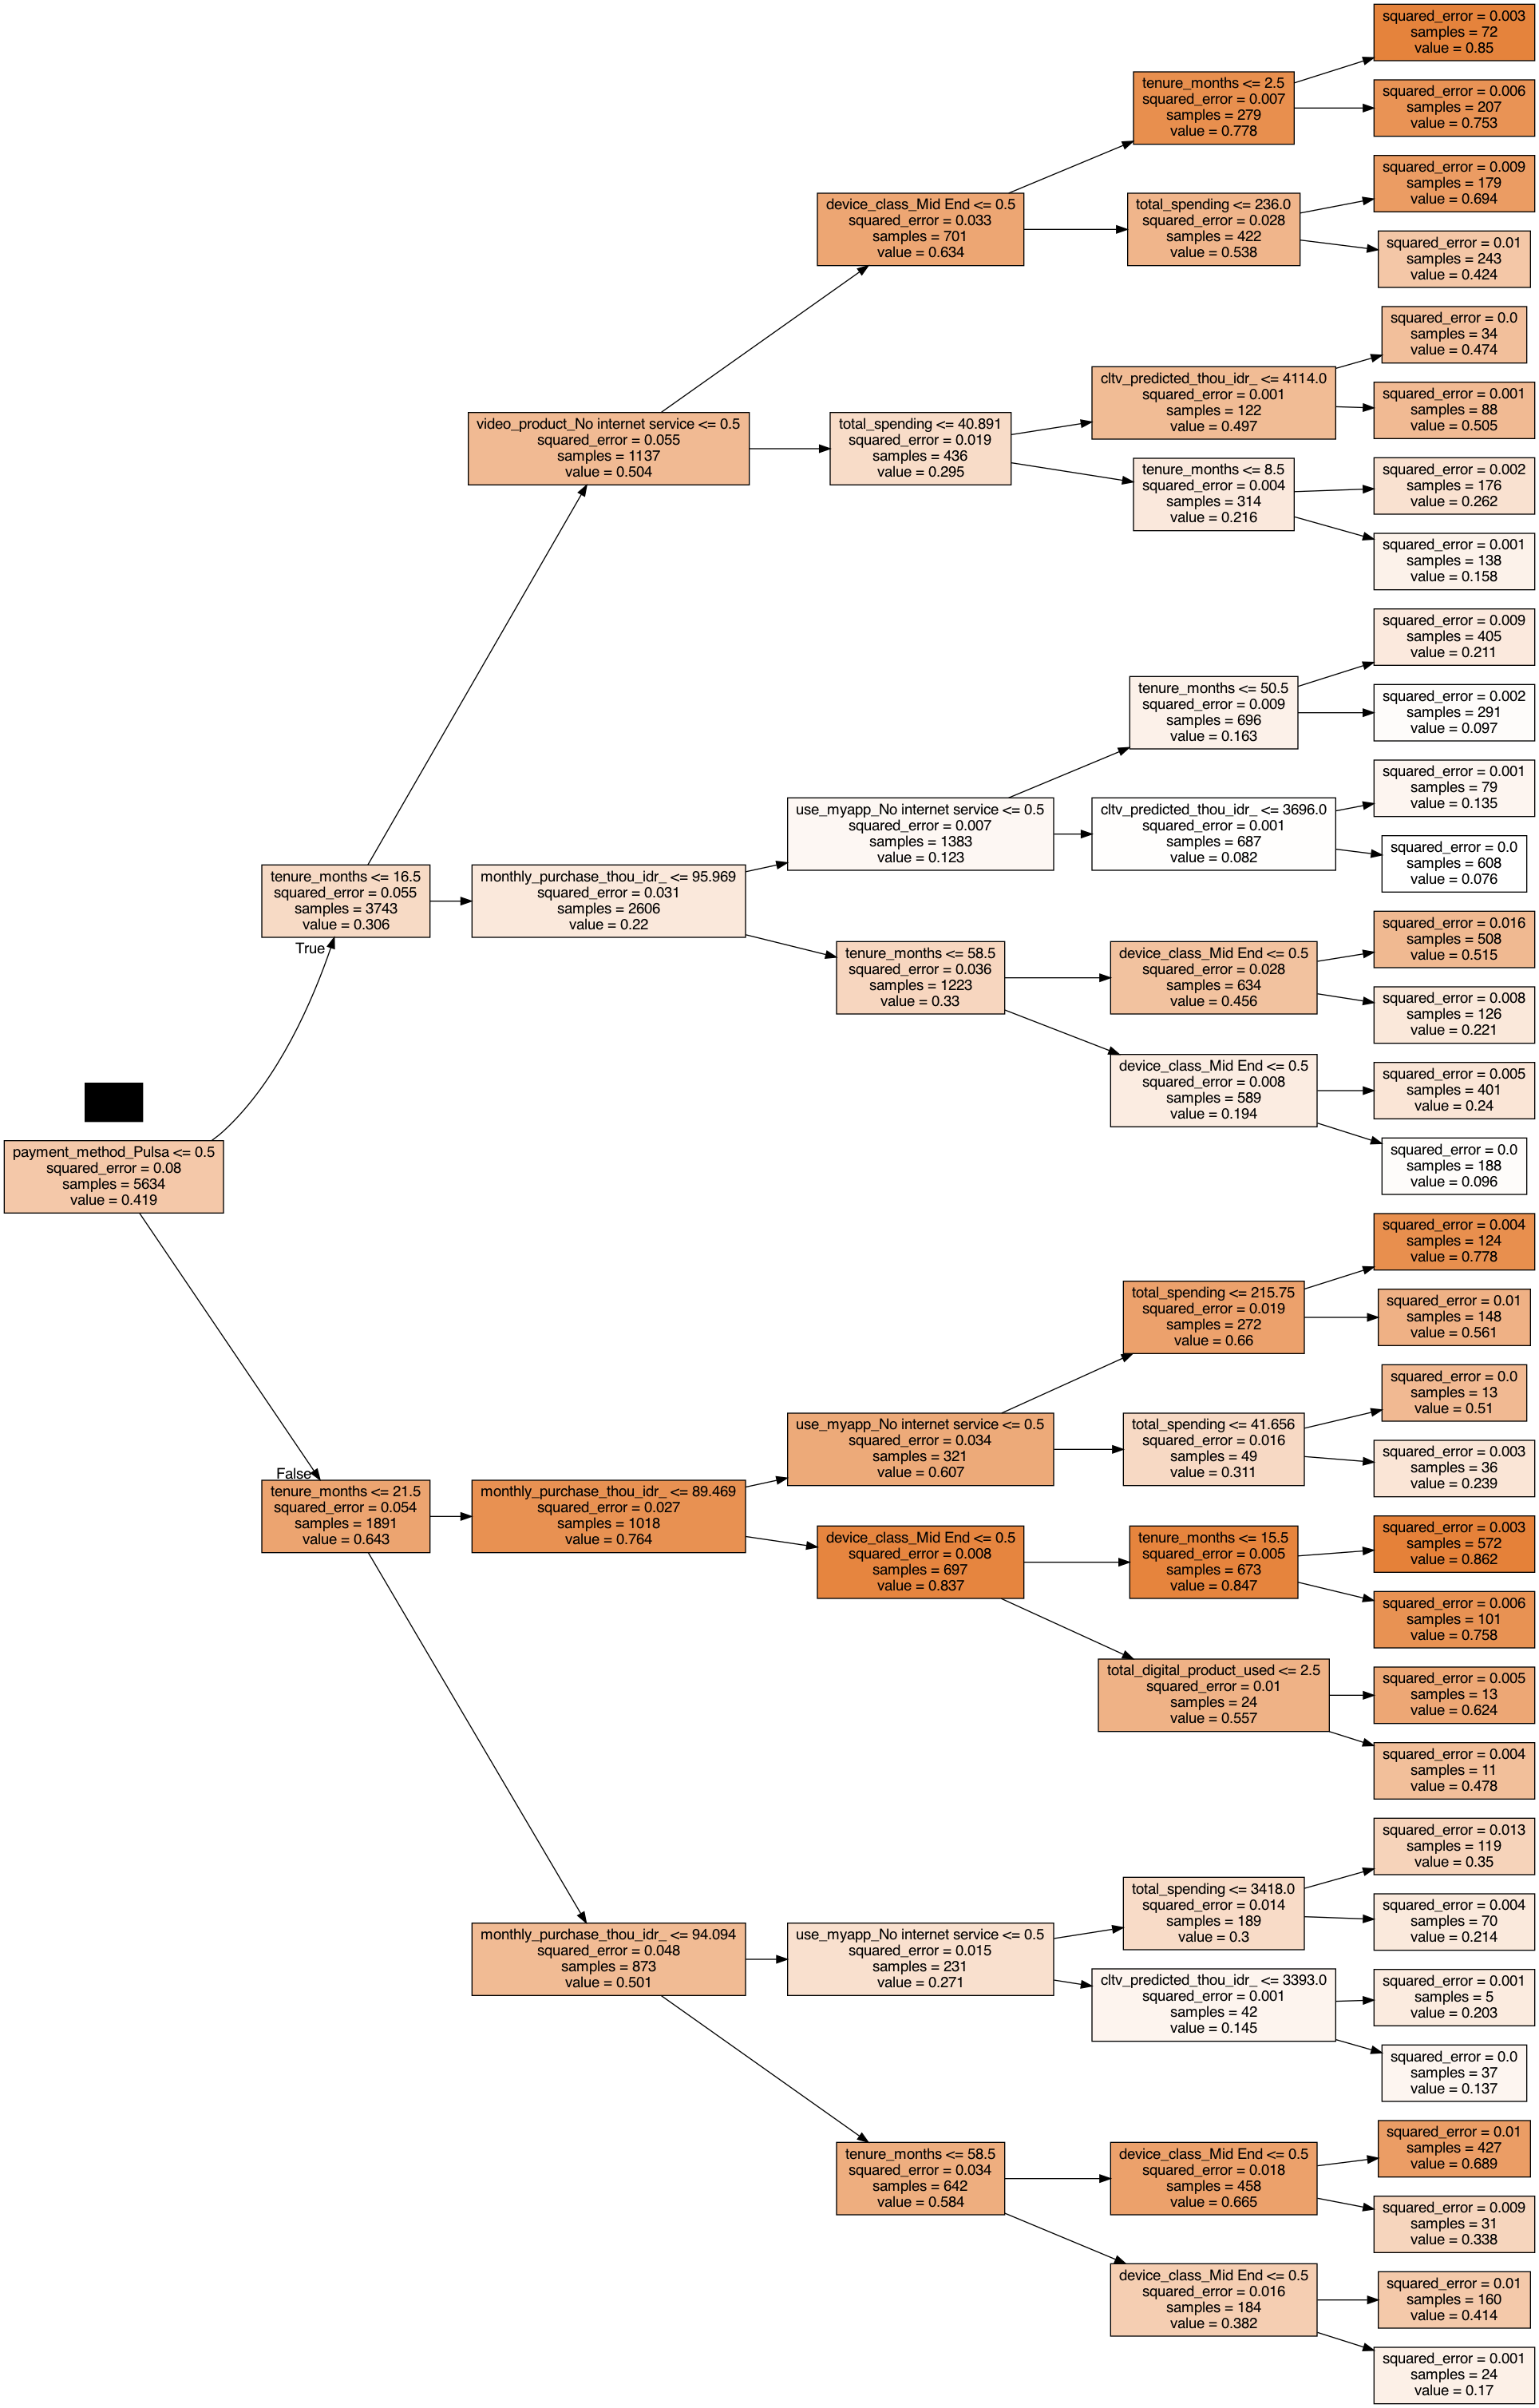

In [38]:
# Display the .png in Jupyter Lab
display(Image(filename='img/sur-sk.png'))

**Insights:**
1. A surrogate model is a simple model to approximate the predictions of a more complex model. The main reason for using a surrogate model is to gain insight into the workings of the complex model, especially when the original model is a black-box (in this case, XGBoost). Here, we use DecisionTree due to its interpretability

2. Surrogate model can also provide insight into interactions. Nodes that split on a different feature than a parent node often have an interaction. It looks like contact_unknown and day might have some interactions

### xgbfir (Feature Interactions Reshaped)

In [39]:
xgbfir.saveXgbFI(loaded_model_xgboost,
                 feature_names=feature_names,
                 OutputXlsxFile='xgbfir.xlsx')

In [40]:
xgbfir = pd.read_excel('xgbfir.xlsx', sheet_name='Interaction Depth 0')
pd.DataFrame(xgbfir
             .sort_values(by='Average Rank')
             .round(1)
            )

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,tenure_months,1477.6,175,82.7,0.5,8.4,1273.6,1,3,1,4,2,1,2.0,44.8,1.5
2,payment_method_Pulsa,472.5,39,20.6,0.5,12.1,425.8,3,7,7,2,1,2,3.7,42.5,1.4
1,monthly_purchase_thou_idr_,571.3,199,71.0,0.4,2.9,380.3,2,2,2,8,6,3,3.8,50.8,2.0
3,device_class_Low End,292.6,46,22.3,0.5,6.4,156.9,4,6,6,3,4,4,4.5,35.7,1.4
10,call_center_Yes,65.0,34,14.1,0.4,1.9,42.9,11,9,8,6,10,6,8.3,49.9,1.9
8,games_product_Yes,75.1,39,13.8,0.4,1.9,41.9,9,8,9,9,9,7,8.5,49.8,1.9
9,tenure_segmentation,71.2,10,4.6,0.5,7.1,69.8,10,17,13,5,3,5,8.8,52.4,1.7
5,cltv_predicted_thou_idr_,102.9,217,48.5,0.2,0.5,37.3,6,1,3,16,20,9,9.2,52.0,2.6
6,device_class_Mid End,76.7,32,11.2,0.3,2.4,30.6,7,10,10,10,8,10,9.2,30.4,2.2
4,total_spending,136.6,151,27.3,0.2,0.9,40.6,5,5,5,20,14,8,9.5,46.1,2.5


In [41]:
xgbfir_depth1 = pd.read_excel('xgbfir.xlsx', sheet_name='Interaction Depth 1')
pd.DataFrame(xgbfir_depth1
             .sort_values(by='Average Rank')
             .round(1)
            )

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,monthly_purchase_thou_idr_|tenure_months,1962.9,128,47.6,0.4,15.3,928.3,1,1,1,22,9,1,5.8,42.5,1.7
1,payment_method_Pulsa|tenure_months,1310.0,24,10.7,0.4,54.6,655.0,2,12,5,14,1,2,6.0,19.2,1.2
2,device_class_Low End|tenure_months,998.3,29,11.6,0.4,34.4,468.4,3,9,2,20,4,3,6.8,25.2,1.6
9,monthly_purchase_thou_idr_|total_digital_produ...,127.7,14,4.6,0.3,9.1,58.6,10,20,13,25,22,5,15.8,41.8,2.2
6,device_class_Mid End|monthly_purchase_thou_idr_,147.6,18,5.2,0.3,8.2,53.4,7,14,11,36,24,7,16.5,37.4,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,music_product_Yes|tenure_months,4.8,2,0.3,0.2,2.4,1.0,94,85,89,80,76,90,85.7,79.5,2.0
99,total_digital_product_used|total_spending,3.6,2,0.3,0.2,1.8,0.9,100,86,88,79,81,92,87.7,97.0,1.5
88,location_Jakarta|total_spending,5.3,7,0.2,0.0,0.8,0.2,89,46,97,99,100,99,88.3,46.6,3.0
91,tenure_segmentation|total_spending,4.8,3,0.3,0.1,1.6,0.5,92,75,95,97,85,97,90.2,72.7,3.0


In [42]:
pd.DataFrame(xgbfir
             .sort_values(by='Average Rank')
             .round(1)
            ).to_csv('xgbfir_no_interaction_sorted_avg_rank', index=False)

In [43]:
pd.DataFrame(xgbfir_depth1
             .sort_values(by='Average Rank')
             .round(1)
            ).to_csv('xgbfir_interaction_sorted_avg_rank', index=False)

### SHAP (no_client)

In [44]:
no_client = {'Customer ID': 7042,
             'Tenure Months': 66,
             'Location': 'Jakarta',
             'Device Class': 'High End',
             'Games Product': 'Yes',
             'Music Product': 'No',
             'Education Product': 'Yes',
             'Call Center': 'Yes',
             'Video Product': 'Yes',
             'Use MyApp': 'Yes',
             'Payment Method': 'Debit',
             'Monthly Purchase (Thou. IDR)': 137.345,
             # 'churn_label': 0,
             'Longitude': 106.816666,
             'Latitude': -6.2,
             'CLTV (Predicted Thou. IDR)': 6626.1}

no_client = pd.DataFrame(no_client, index=range(1))
no_client

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,7042,66,Jakarta,High End,Yes,No,Yes,Yes,Yes,Yes,Debit,137.345,106.816666,-6.2,6626.1


In [45]:
no_client_transformed = loaded_pipeline_xgboost.transform(no_client)

In [46]:
shap_ex = shap.TreeExplainer(loaded_model_xgboost)
vals = shap_ex(pd.DataFrame(no_client_transformed, columns=feature_names))

shap_df = pd.DataFrame(vals.values, columns=feature_names)
shap_df

,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_No internet service,games_product_Yes,music_product_No internet service,music_product_Yes,education_product_No internet service,education_product_Yes,video_product_No internet service,video_product_Yes,call_center_Yes,use_myapp_No internet service,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,tenure_months,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,-0.001807,0.051009,0.03863,0.007755,-0.180423,0.0,0.064242,0.0,-0.017113,0.0,0.015957,-0.238831,0.0,0.032464,0.023743,0.023494,-0.201863,-0.030281,-1.093774,0.000227,0.004922,-0.075072,-0.080151,0.845857,-0.074233,-0.121356,0.038236


In [47]:
print(pd.concat([shap_df.sum(axis='columns')
                        .rename('pred') + vals.base_values,
                pd.Series(0, name='true')], axis='columns')
                  .assign(prob=lambda adf: (np.exp(adf.pred) / (1+np.exp(adf.pred)))))

       pred  true     prob
0 -0.953758     0  0.27813


In [48]:
shap_ex.expected_value

0.014611612

In [49]:
# < 0 therefore ... "no"
shap_ex.expected_value + vals.values[0].sum()

-0.95375764

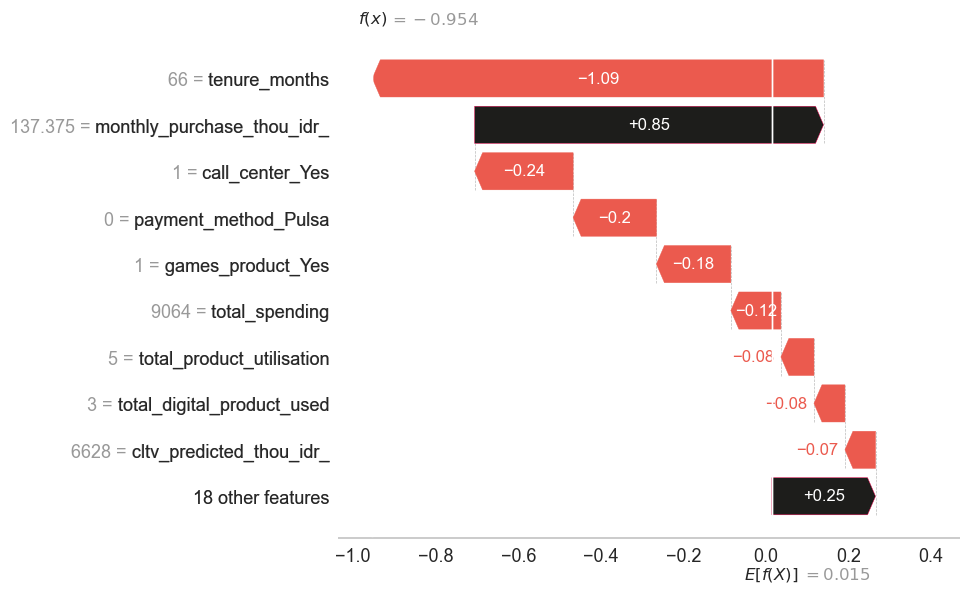

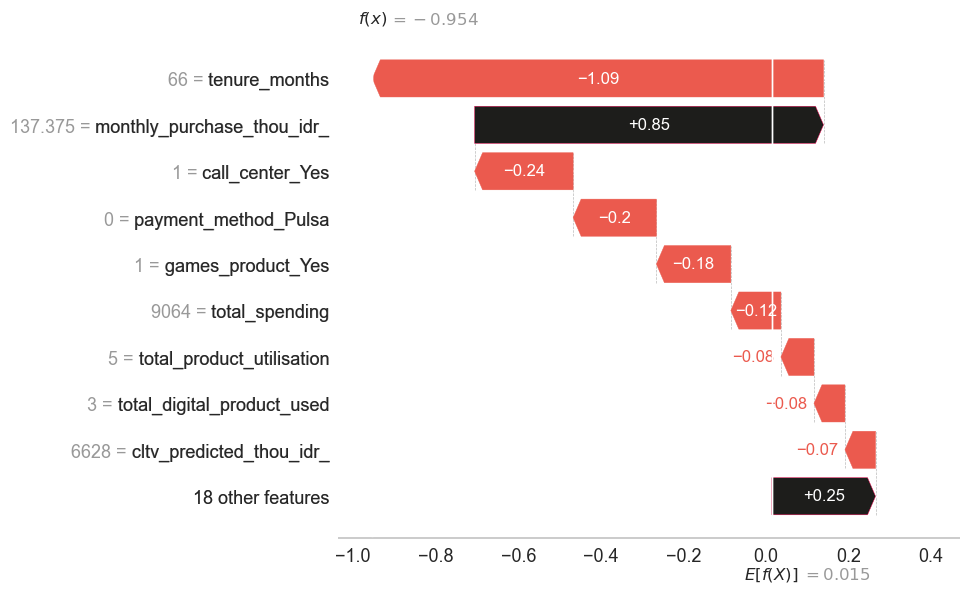

In [50]:
# Waterfall plot to explore SHAP values. 
# This plots an explanation of a single prediction.
# It displays how the SHAP value from each column impacts the result
# Default SHAP colors
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# Custom colors
positive_color = color_palette[7]
negative_color = color_palette[2]
fig.clf()       
fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig

In [51]:
fig.clf()
res = shap.plots.force(base_value=vals.base_values,
                       shap_values=vals.values[0,:],
                       features=feature_names,
                       matplotlib=True,
                       show=False,
                       plot_cmap=[positive_color, negative_color])
res.savefig('img/shap_forceplot_no_churn.png', dpi=600, bbox_inches='tight')

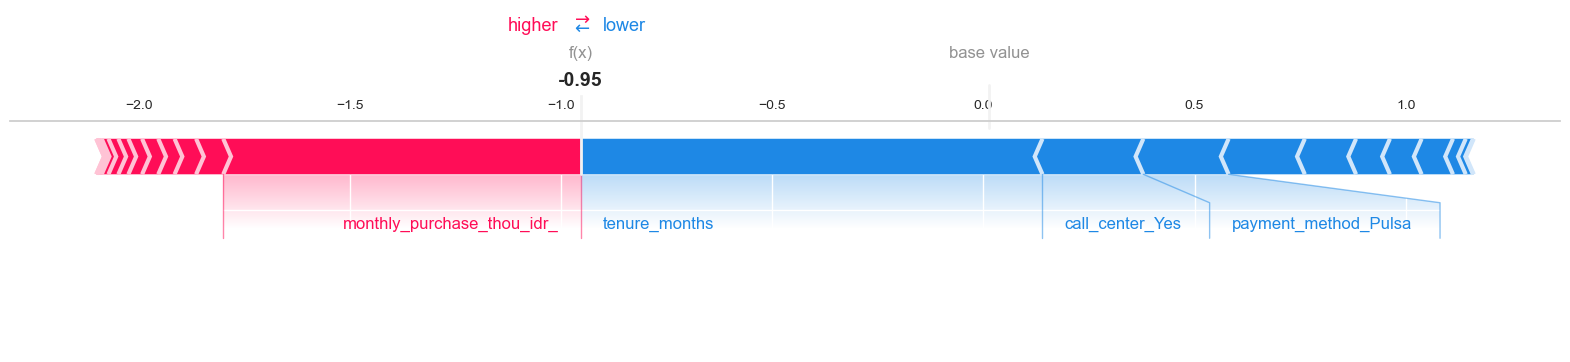

In [52]:
res

### SHAP (yes_client)

In [53]:
yes_client = {'Customer ID': 0,
              'Tenure Months': 2,
              'Location': 'Jakarta',
              'Device Class': 'Mid End',
              'Games Product': 'Yes',
              'Music Product': 'Yes',
              'Education Product': 'No',
              'Call Center': 'No',
              'Video Product': 'No',
              'Use MyApp': 'No',
              'Payment Method': 'Digital Wallet',
              'Monthly Purchase (Thou. IDR)': 70.00500000000001,
              # 'churn_label': 1,
              'Longitude': 106.816666,
              'Latitude': -6.2,
              'CLTV (Predicted Thou. IDR)': 4210.7}
yes_client = pd.DataFrame(yes_client, index=range(1))
yes_client

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,106.816666,-6.2,4210.7


In [54]:
yes_client_transformed = loaded_pipeline_xgboost.transform(yes_client)

In [55]:
shap_ex = shap.TreeExplainer(loaded_model_xgboost)
vals = shap_ex(pd.DataFrame(yes_client_transformed, columns=feature_names))

shap_df = pd.DataFrame(vals.values, columns=feature_names)
shap_df

,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_No internet service,games_product_Yes,music_product_No internet service,music_product_Yes,education_product_No internet service,education_product_Yes,video_product_No internet service,video_product_Yes,call_center_Yes,use_myapp_No internet service,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,tenure_months,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,-0.0042,0.119148,-0.20141,0.019241,-0.320647,0.0,-0.125128,0.0,0.003464,0.0,-0.024946,0.084973,0.0,-0.029986,-0.006143,-0.095807,-0.116311,0.077776,0.935334,0.003039,0.001822,-0.012126,0.047363,-0.38112,-0.118631,0.134911,-0.063326


In [56]:
print(pd.concat([shap_df.sum(axis='columns')
                        .rename('pred') + vals.base_values,
                pd.Series(1, name='true')], axis='columns')
                  .assign(prob=lambda adf: (np.exp(adf.pred) / (1+np.exp(adf.pred)))))

       pred  true      prob
0 -0.058101     1  0.485479


In [57]:
# Since this is below zero, the default is "no"
shap_ex.expected_value

0.014611612

In [58]:
# > 0 therefore ... "yes"
shap_ex.expected_value + vals.values[0].sum()

-0.058100764

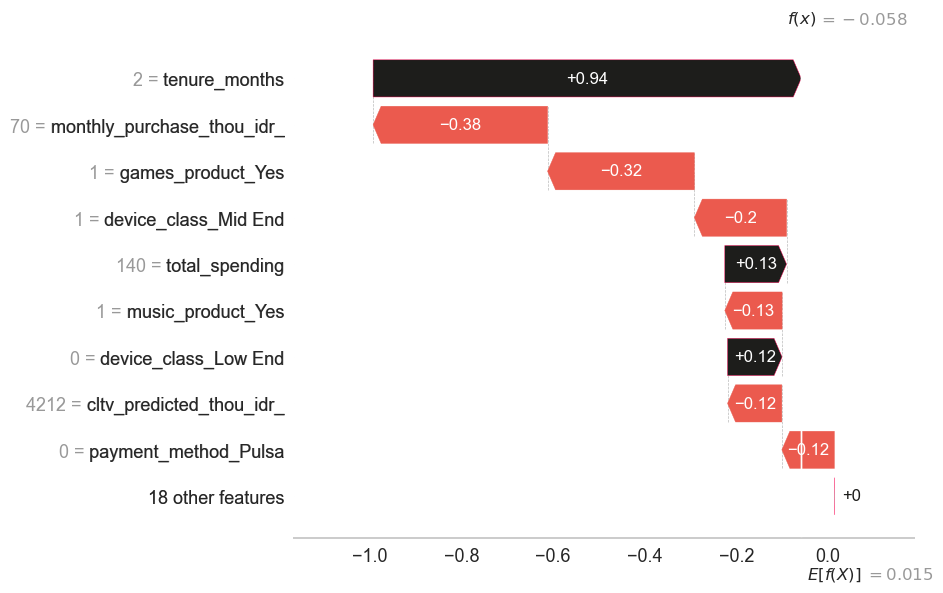

In [59]:
# Waterfall plot to explore SHAP values. 
# This plots an explanation of a single prediction.
# It displays how the SHAP value from each column impacts the result
fig.clf()
fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig

In [60]:
fig.clf()
res = shap.plots.force(base_value=vals.base_values,
                       shap_values=vals.values[0,:],
                       features=feature_names,
                       matplotlib=True,
                       show=False,
                       plot_cmap=[positive_color, negative_color],)
res.savefig('img/shap_forceplot_yes_churn.png', dpi=600, bbox_inches='tight')

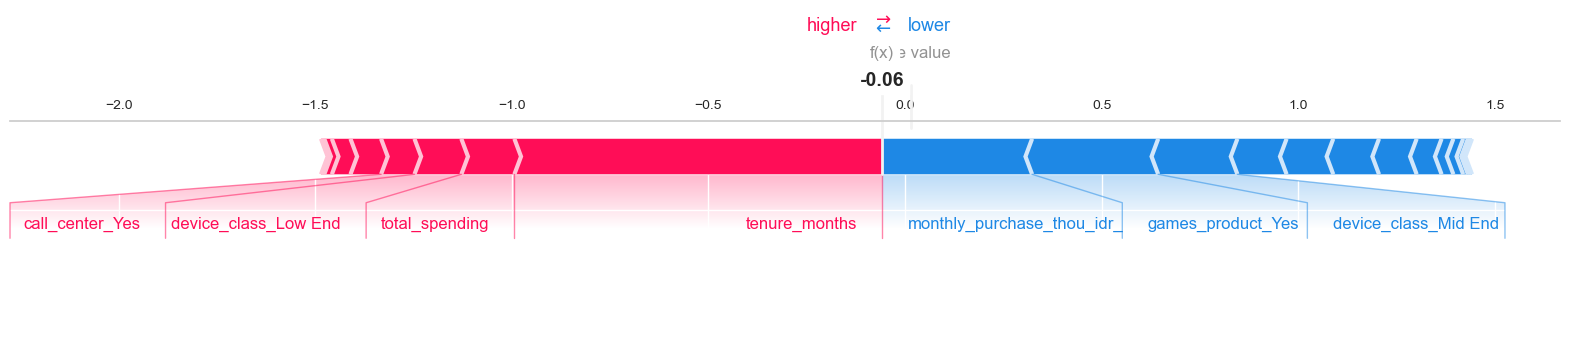

In [61]:
res

In [62]:
shap_ex = shap.TreeExplainer(loaded_model_xgboost)
vals = shap_ex(pd.DataFrame(loaded_pipeline_xgboost.transform(X_test), columns=feature_names))

shap_df = pd.DataFrame(vals.values, columns=feature_names)
shap_df

,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_No internet service,games_product_Yes,music_product_No internet service,music_product_Yes,education_product_No internet service,education_product_Yes,video_product_No internet service,video_product_Yes,call_center_Yes,use_myapp_No internet service,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,tenure_months,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,-0.001488,0.046056,0.032264,0.007591,-0.159177,0.0,-0.079114,0.0,-0.010449,0.0,0.016747,-0.200027,0.0,0.028176,-0.007178,0.015272,-0.199758,-0.028885,-1.459542,0.001718,-0.061963,-0.086540,-0.084895,0.578958,-0.058047,-0.139865,0.172599
1,-0.007124,0.132217,0.094727,0.019178,0.077638,0.0,0.069318,0.0,0.004094,0.0,0.039852,-0.351034,0.0,0.039830,-0.009328,0.033250,-0.149978,0.056831,0.773608,0.002288,0.003346,0.048662,-0.011635,0.885872,-0.017031,0.027809,0.091163
2,-0.018045,0.062830,-0.274635,0.015327,-0.249658,0.0,-0.082008,0.0,-0.019125,0.0,0.018627,0.081060,0.0,-0.023162,-0.006070,0.026522,-0.181686,-0.016525,-0.353855,0.000269,-0.062542,-0.129739,-0.066752,0.006137,0.130595,-0.012566,0.169478
3,-0.011267,0.105568,0.082667,0.018781,0.086340,0.0,0.057291,0.0,-0.005685,0.0,-0.023557,-0.282265,0.0,-0.016089,-0.006218,0.027925,0.378300,-0.013970,0.220212,0.002195,0.002175,0.061198,0.032969,0.210465,0.121775,-0.154325,-0.112420
4,-0.010418,0.047413,-0.150650,0.012463,-0.200945,0.0,-0.078676,0.0,-0.019422,0.0,0.014968,0.091185,0.0,0.038178,-0.008877,0.016658,-0.218901,-0.033586,-1.546480,0.000481,-0.053790,-0.107897,-0.096130,-0.130371,-0.078331,-0.047881,-0.039282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.021764,0.043823,-0.231018,0.010915,-0.195969,0.0,-0.084378,0.0,-0.023620,0.0,0.017416,-0.315722,0.0,0.039537,-0.008222,-0.078219,-0.235315,-0.030096,-0.505847,0.000309,-0.078728,-0.115266,-0.150332,-0.008063,-0.086993,-0.083698,0.062122
1405,-0.006467,-0.516170,0.020425,-0.097986,0.034889,0.0,0.032973,0.0,0.003148,0.0,-0.032708,0.039529,0.0,-0.037532,-0.018214,0.028611,-0.214258,-0.027642,-0.431078,-0.003161,0.001173,0.026575,-0.010457,-1.021894,0.023131,-0.169723,-0.072639
1406,0.010010,-0.703479,0.024286,-0.100117,0.045071,0.0,0.031821,0.0,0.001010,0.0,-0.022836,0.059317,0.0,-0.021627,0.078681,0.034659,-0.151360,0.050908,0.702763,-0.002150,0.001076,0.022689,-0.021154,-0.783327,-0.072857,0.064895,0.085386
1407,-0.000044,-0.441940,0.012218,-0.084889,0.033923,0.0,0.026048,0.0,0.001268,0.0,-0.032992,0.053140,0.0,-0.039091,0.083431,0.031672,-0.251525,-0.028980,-0.686248,-0.003598,0.001860,0.020739,-0.033438,-0.958485,-0.015452,-0.099616,0.013280


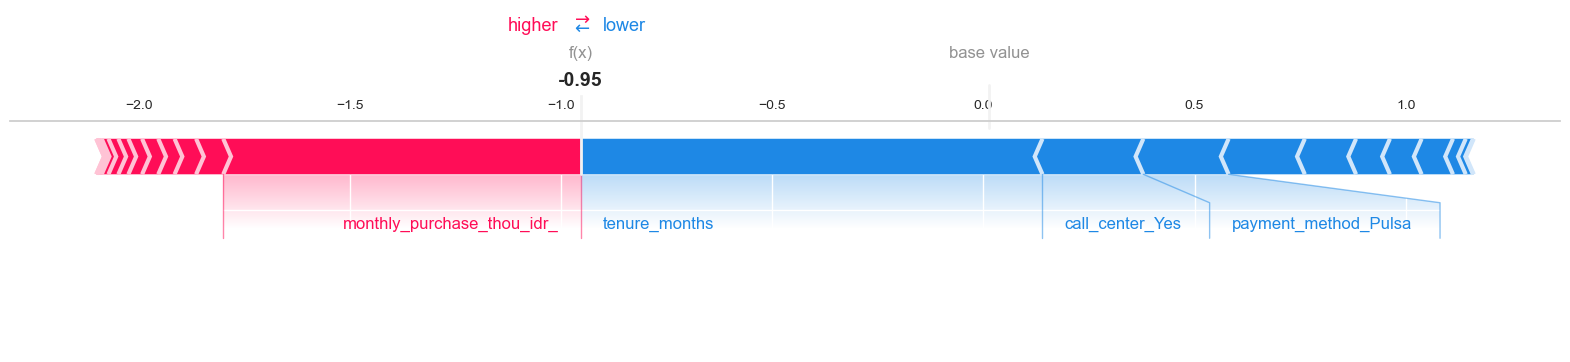

<Figure size 800x650 with 0 Axes>

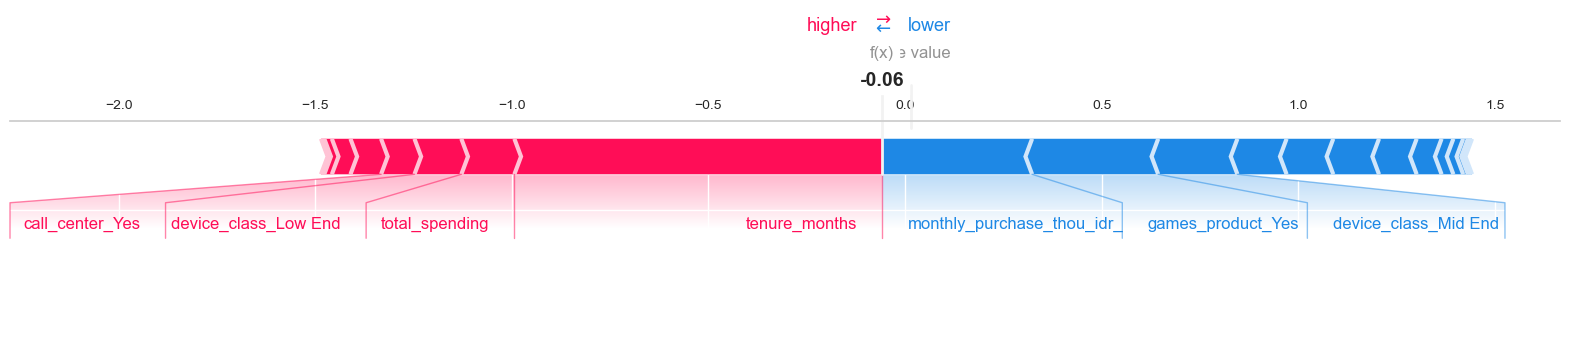

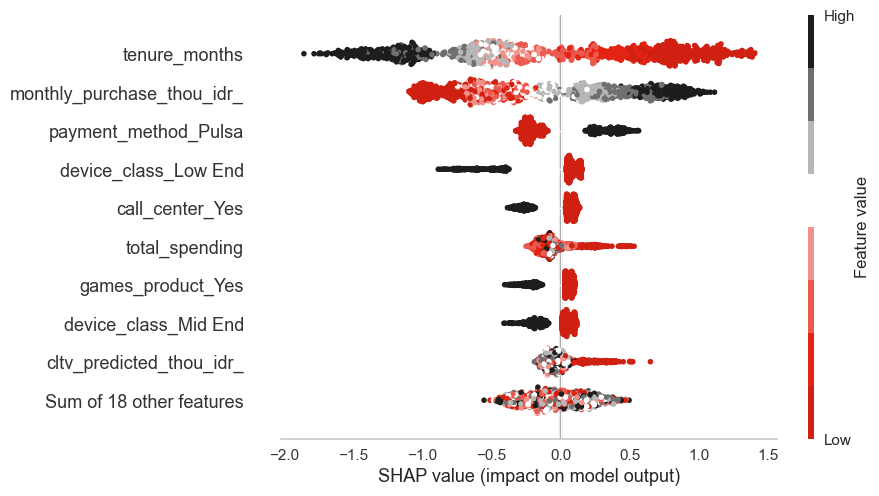

In [63]:
fig.clf()
fig = plt.figure(figsize=(8, 4))
fig = shap.plots.beeswarm(vals, color=cm)
fig;

**Notes:**
1. The features higher up in the plot are generally more important for the model. Importance is often determined by the absolute SHAP values.
2. Each dot on the x-axis represents a SHAP value for an instance in the dataset. A SHAP value quantifies the impact of a feature on the model's output, compared to the output's baseline value.
3. Zero Line: The vertical line at zero on the x-axis. Features that push the prediction higher than the expected value are plotted to the right of the zero line, and features that push the prediction lower are plotted to the left.
4. If for a particular feature there are more dots to the right of the zero line, it generally implies that for those instances, the feature contributes to pushing the model's prediction closer to Class 1. Conversely, if more dots were to the left, it would indicate a tendency for that feature to contribute towards Class 0.

### ICE, PDP

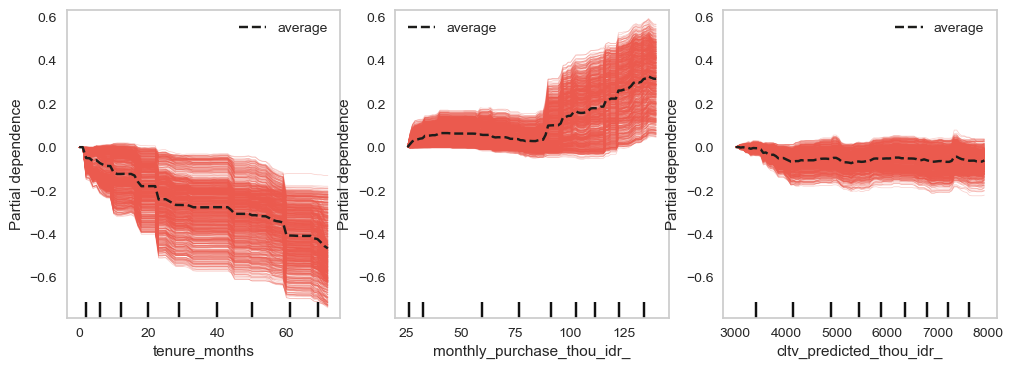

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
PartialDependenceDisplay.from_estimator(loaded_model_xgboost, 
                                        pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names),
                                        features=['tenure_months', 'monthly_purchase_thou_idr_', 'cltv_predicted_thou_idr_'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[2]},
                                        pd_line_kw={"color": color_palette[7]})
plt.show();
plt.clf();

<Figure size 800x550 with 0 Axes>

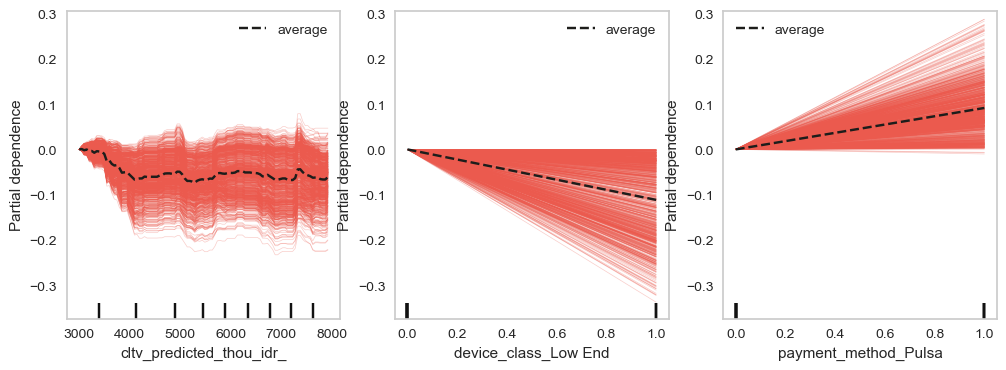

In [65]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
PartialDependenceDisplay.from_estimator(loaded_model_xgboost, 
                                        pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names),
                                        features=['cltv_predicted_thou_idr_', 'device_class_Low End', 'payment_method_Pulsa'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[2]},
                                        pd_line_kw={"color": color_palette[7]})
plt.show();
plt.clf();

<Figure size 800x550 with 0 Axes>

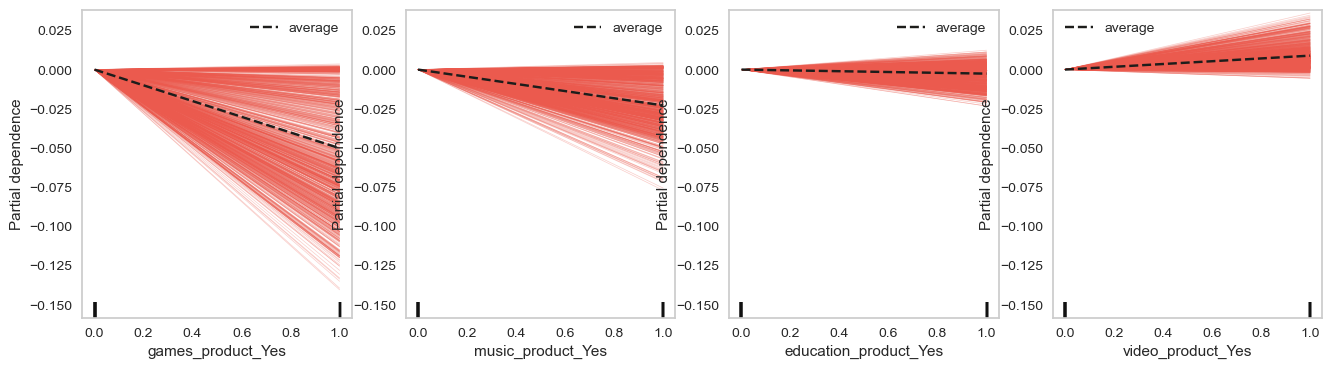

In [66]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))
PartialDependenceDisplay.from_estimator(loaded_model_xgboost, 
                                        pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names),
                                        features=['games_product_Yes', 'music_product_Yes', 'education_product_Yes', 'video_product_Yes'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[2]},
                                        pd_line_kw={"color": color_palette[7]})
plt.show();
plt.clf();

<Figure size 800x550 with 0 Axes>

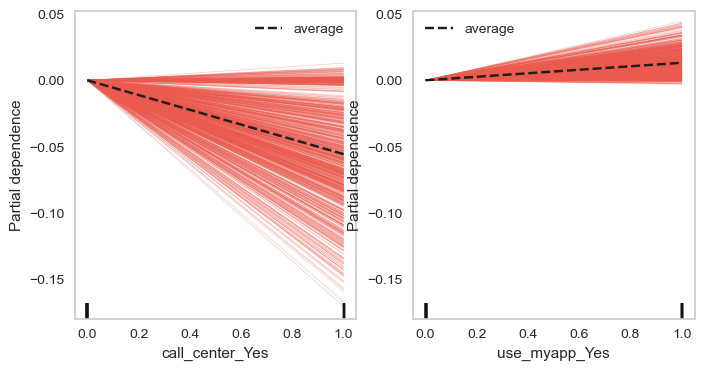

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(loaded_model_xgboost, 
                                        pd.DataFrame(loaded_pipeline_xgboost.transform(X_train), columns=feature_names),
                                        features=['call_center_Yes', 'use_myapp_Yes'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[2]},
                                        pd_line_kw={"color": color_palette[7]})
plt.show();
plt.clf();